## Import Packages needed for data import and Wrangling

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.html.widgets import *
import plotly as py
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import os
import json
import time
import pickle
import requests
from pandas.plotting import scatter_matrix


%matplotlib inline

C:\Users\Doug\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Set up config parameters for importing data

Referencing these parameters will be easier.

In [2]:
##Our data is stored in an AWS MySQL Database
##Let's store the connection information so we can reference it later

CONFIG = {
    'user': 'db_gtown_2018',
    'password': 'Gtown2018',
    'port': '3306',
    'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
    'database': 'db_nfl',
    'raise_on_warnings': True,
}

##Now let's create a query to extract the inputs we need from the database
##This Notebook is focused on forecasting Quarterback Pro Bowl selections, so this query is quarterback specific.

QUERY = """

SELECT 
PASSER.PNAME AS PASSER
, CONCAT(PASSER.PNAME, ', ', GAME.SEAS) AS PASSER_SEAS
, CASE WHEN PASSER_PRO_BOWL.PLAYER_ID IS NOT NULL
THEN 1
ELSE 0
END AS PASSER_PRO_BOWL

, CASE WHEN PASSER.DPOS > 0
THEN PASSER.DPOS
ELSE 256
END AS PASSER_DRAFT_SPOT
, CASE WHEN PASSER.DPOS > 0
THEN 1
ELSE 0
END AS PASSER_DRAFTED 

,TARGET.PNAME AS TARGET
,CASE WHEN PASS_FULL.LOC IN ('DL', 'DM', 'DR')
THEN 1
ELSE 0
END AS DEEP_PASS
,CASE WHEN PASS_FULL.LOC IN ('L', 'M', 'R', 'NL')
THEN 1
ELSE 0
END AS MED_PASS
,CASE WHEN PASS_FULL.LOC IN ('SL', 'SM', 'SR')
THEN 1
ELSE 0
END AS SHORT_PASS
, PASS_FULL.YDS
, 1 AS PASS_ATTEMPT
, PASS_FULL.COMP
, PASS_FULL.TD
, PASS_FULL.INTRCPT
, PASSER_RATING.PASS_RAT
, PASSER.HEIGHT AS PASSER_HGHT
, GAME.SEAS - RIGHT(PASSER.DOB,4) AS PASSER_AGE
, PASSER.START AS PASSER_CAREER_STRT
/*, GAME.SEAS - */
, TARGET.HEIGHT AS TGT_HGHT
, TARGET.WEIGHT AS TGT_WGHT
, CASE WHEN TARGET_PRO_BOWL.PLAYER_ID IS NOT NULL
THEN 1
ELSE 0
END AS TARGET_PRO_BOWL

, GAME.SEAS - RIGHT(TARGET.DOB,4) AS TGT_AGE
, CASE WHEN TARGET.DPOS IS NULL
THEN 256
WHEN TARGET.DPOS = 0
THEN 256
ELSE TARGET.DPOS
END AS TGT_DRAFT_SPOT
, CASE WHEN TARGET.DPOS > 0
THEN 1
ELSE 0
END AS TGT_DRAFTED 
, TARGET.START AS TGT_CAREER_STRT /*'USE TO FIGURE OUT YEARS IN LEAGUE'*/
, CASE WHEN TARGET.FORTY = 0
THEN ROUND(AVERAGE_FORTY.AVG_FORTY,3)
ELSE TARGET.FORTY
END AS TGT_FORTY
, CASE WHEN TARGET.VERTICAL = 0
THEN ROUND(AVERAGE_VERTICAL.AVG_VERT,3)
ELSE TARGET.VERTICAL
END AS TGT_VERT
, CASE WHEN TARGET.POS1 = 'RB'
THEN 1
ELSE 0
END AS RB_TGT
, CASE WHEN TARGET.POS1 = 'WR'
THEN 1
ELSE 0
END AS WR_TGT
, CASE WHEN TARGET.POS1 = 'TE'
THEN 1
ELSE 0
END AS TE_TGT
, CASE WHEN TARGET.POS1 <> 'RB'
AND TARGET.POS1 <> 'TE'
AND TARGET.POS1 <> 'WR'
THEN 1
ELSE 0
END AS TRICK_PLAY

/*,QTR
,MIN *//*'CAN BE USED FOR TWO MIN DRILL'*/
, YTG
, Case when PASS_FULL.YDS >= YTG
THEN 1
ELSE 0
END AS FIRST_DOWN_CONVERSION

, CASE WHEN ZONE = 5
THEN 1
ELSE 0
END AS RED_ZONE_ATTMPT /*'DEFINITION AVAILABLE'*/
, CASE WHEN ZONE = 5
THEN PASSER_RATING.PASS_RAT
ELSE NULL
END AS RED_ZONE_QB_RAT /*'DEFINITION AVAILABLE'*/
, CASE WHEN DWN = 4
AND PASS_FULL.YDS >= YTG
THEN 1
when DWN = 4
AND PASS_FULL.YDS < YTG
THEN 0
ELSE NULL
END
AS FOURTH_DOWN_SUCCESS
, CASE WHEN DWN = 3
AND PASS_FULL.YDS >= YTG
THEN 1
when DWN = 3
AND PASS_FULL.YDS < YTG
THEN 0
ELSE NULL
END
AS THIRD_DOWN_SUCCESS
, CASE WHEN QTR = 4
THEN PASSER_RATING.PASS_RAT
ELSE null
END AS FOURTH_QTR_PASS_RAT
, CASE WHEN SG = 'Y'
THEN 1 
ELSE 0
END as SHOTGUN
, CASE WHEN NH = 'Y'
THEN 1
ELSE 0
END AS  NO_HUDDLE
, CASE WHEN PENALTY.ACT IS NOT NULL
THEN 1
ELSE 0
END AS DEF_PENALTY_DCLND
,CASE WHEN PENALTY.ACT IS NOT NULL
THEN PASSER_RATING.PASS_RAT
ELSE NULL
END AS FREE_PLAY_PASS_RAT
, PENALTY.DESC as PENALTY_DESC
,GAME.SEAS
/* ,GAME.WK
,GAME.DAY
,GAME.V 'FIGURE OUT HOW TO DO HOME OR AWAY'
,GAME.H*/
/*HOW DO WE CALCULATE WHETHER THE PASSER IS AT HOME OR AWAY?*/
,GAME.TEMP
,GAME.HUMD
,GAME.WSPD
,case when COND IN ('Rain', 'Showers', 'Snow', 'Thunderstorms', 'Cold'
,'Flurries'
,'Light Rain'
,'Light Showers'
,'Light Snow'
,'Windy'
)
THEN 1
ELSE 0
END AS BAD_WEATH
, case when COND IN ('Chance Rain'
,'Clear'
,'Closed Roof'
,'Cloudy'
,'Covered Roof'
,'Dome'
,'Fair'
,'Foggy'
,'Hazy'
,'Mostly Cloudy'
,'Mostly Sunny'
,'Overcast'
,'Partly Cloudy'
,'Partly Sunny'
,'Sunny' )
THEN 1
WHEN COND IS NULL
THEN 1
ELSE 0
END AS GOOD_WEATH
,GAME.COND
, CASE WHEN GAME.COND = 'DOME'
THEN 1
ELSE 0
END AS DOME_GAME
, CASE WHEN GAME.SURF <> 'GRASS'
THEN 1
ELSE 0
END AS TURF_FIELD
, CASE WHEN POSTSEASON_RUN.FINAL_WK >17
THEN 1
ELSE 0
END AS POSTSEASON
,  CASE WHEN POSTSEASON_RUN.FINAL_WK >18
THEN 1
ELSE 0
END AS DIVISIONAL_APPEARANCE
, CASE 
WHEN PASSER_PRO_BOWL_PRIOR.PLAYER_ID IS NULL
THEN 0
ELSE 1
END AS PASSER_PRO_BOWL_LAST_YEAR
,NULL AS RUSH_YDS
,NULL AS RUSH_SUCCESS
, NULL AS RUSH_TD
, NULL AS FUMBLE
 FROM PBP
 INNER JOIN PASS_FULL
 ON PBP.PID = PASS_FULL.PID
left outer join GAME
ON PBP.GID = GAME.GID
LEFT OUTER JOIN PENALTY
ON PBP.PID = PENALTY.PID
AND PENALTY.CAT = '4'
AND PENALTY.ACT = 'D'
INNER JOIN PLAYER PASSER
ON PASS_FULL.PSR = PASSER.PLAYER
LEFT OUTER JOIN PLAYER TARGET
ON PASS_FULL.TRG = TARGET.PLAYER
LEFT OUTER JOIN PASSER_RATING
ON PASS_FULL.YDS = PASSER_RATING.YDS
AND PASS_FULL.COMP = PASSER_RATING.COMPL
AND PASS_FULL.TD = PASSER_RATING.TD
AND PASS_FULL.INTRCPT = PASSER_RATING.INTRCPT
LEFT OUTER JOIN (SELECT 
POS1
, AVG(FORTY) AS AVG_FORTY
,COUNT(*)
FROM PLAYER
WHERE FORTY > 0
GROUP BY 
POS1) AVERAGE_FORTY
ON TARGET.POS1 = AVERAGE_FORTY.POS1
LEFT OUTER JOIN
(SELECT 
POS1
, AVG(VERTICAL) AS AVG_VERT
,COUNT(*)
FROM PLAYER
WHERE VERTICAL > 0
GROUP BY 
POS1) AVERAGE_VERTICAL
ON TARGET.POS1 = AVERAGE_VERTICAL.POS1
LEFT OUTER JOIN PRO_BOWL PASSER_PRO_BOWL
ON GAME.SEAS = PASSER_PRO_BOWL.ProBowl_Year
AND PASSER.PLAYER = PASSER_PRO_BOWL.PLAYER_ID
LEFT OUTER JOIN PRO_BOWL PASSER_PRO_BOWL_PRIOR
ON (GAME.SEAS -1) = PASSER_PRO_BOWL_PRIOR.ProBowl_Year
AND PASSER.PLAYER = PASSER_PRO_BOWL_PRIOR.PLAYER_ID
LEFT OUTER JOIN PRO_BOWL TARGET_PRO_BOWL
ON GAME.SEAS = TARGET_PRO_BOWL.ProBowl_Year
AND TARGET.PLAYER = TARGET_PRO_BOWL.PLAYER_ID
LEFT OUTER JOIN
(SELECT SEAS, TEAM, MAX(FINAL_WK) AS FINAL_WK
FROM (
(SELECT SEAS, V AS TEAM, MAX(WK) AS FINAL_WK FROM GAME VISIT
GROUP BY SEAS, V) 
UNION
(SELECT SEAS, H AS TEAM, MAX(WK) AS FINAL_WK FROM GAME HOME
GROUP BY SEAS, H)
) WIN_RECORD
GROUP BY SEAS, TEAM) POSTSEASON_RUN
ON PBP.OFF = POSTSEASON_RUN.TEAM
AND GAME.SEAS = POSTSEASON_RUN.SEAS


WHERE PASS_FULL.SPK = 0
AND WK <= 17

UNION ALL
SELECT 
RUSHER.PNAME AS PNAME

, CONCAT(RUSHER.PNAME, ', ', GAME.SEAS) AS PASSER_SEAS
, CASE WHEN RUSHER_PRO_BOWL.PLAYER_ID IS NOT NULL
THEN 1
ELSE 0
END AS PASSER_PRO_BOWL

, CASE WHEN RUSHER.DPOS > 0
THEN RUSHER.DPOS
ELSE 256
END AS PASSER_DRAFT_SPOT
, CASE WHEN RUSHER.DPOS > 0
THEN 1
ELSE 0
END AS PASSER_DRAFTED 

,NULL AS TARGET
,NULL AS DEEP_PASS
,NULL AS MED_PASS
,NULL AS SHORT_PASS
, NULL AS YDS
, NULL AS PASS_ATTEMPT
, NULL AS COMP
, NULL AS TD
, NULL AS INTRCPT
, NULL AS PASS_RAT
, RUSHER.HEIGHT AS PASSER_HGHT
, GAME.SEAS - RIGHT(RUSHER.DOB,4) AS PASSER_AGE
, RUSHER.START AS PASSER_CAREER_STRT
/*, GAME.SEAS - */
, NULL AS TGT_HGHT
, NULL AS TGT_WGHT
, NULL AS TARGET_PRO_BOWL

, NULL AS TGT_AGE
, NULL AS TGT_DRAFT_SPOT
, NULL AS TGT_DRAFTED 
, NULL AS TGT_CAREER_STRT /*'USE TO FIGURE OUT YEARS IN LEAGUE'*/
, NULL AS TGT_FORTY
, NULL AS TGT_VERT
, NULL AS RB_TGT
, NULL AS WR_TGT
, NULL AS TE_TGT
, NULL AS TRICK_PLAY

/*,QTR
,MIN *//*'CAN BE USED FOR TWO MIN DRILL'*/
, YTG
, Case when RUSH.YDS >= YTG
THEN 1
ELSE 0
END AS FIRST_DOWN_CONVERSION

, NULL AS RED_ZONE_ATTMPT /*'DEFINITION AVAILABLE'*/
, NULL AS RED_ZONE_QB_RAT /*'DEFINITION AVAILABLE'*/
, CASE WHEN DWN = 4
AND RUSH.YDS >= YTG
THEN 1
when DWN = 4
AND RUSH.YDS < YTG
THEN 0
ELSE NULL
END
AS FOURTH_DOWN_SUCCESS
, CASE WHEN DWN = 3
AND RUSH.YDS >= YTG
THEN 1
when DWN = 3
AND RUSH.YDS < YTG
THEN 0
ELSE NULL
END
AS THIRD_DOWN_SUCCESS
, NULL AS FOURTH_QTR_PASS_RAT
, CASE WHEN SG = 'Y'
THEN 1 
ELSE 0
END as SHOTGUN
, CASE WHEN NH = 'Y'
THEN 1
ELSE 0
END AS  NO_HUDDLE
, CASE WHEN PENALTY.ACT IS NOT NULL
THEN 1
ELSE 0
END AS DEF_PENALTY_DCLND
, NULL AS FREE_PLAY_PASS_RAT
, PENALTY.DESC as PENALTY_DESC
,GAME.SEAS
/* ,GAME.WK
,GAME.DAY
,GAME.V 'FIGURE OUT HOW TO DO HOME OR AWAY'
,GAME.H*/
/*HOW DO WE CALCULATE WHETHER THE PASSER IS AT HOME OR AWAY?*/
,GAME.TEMP
,GAME.HUMD
,GAME.WSPD
,case when COND IN ('Rain', 'Showers', 'Snow', 'Thunderstorms', 'Cold'
,'Flurries'
,'Light Rain'
,'Light Showers'
,'Light Snow'
,'Windy'
)
THEN 1
ELSE 0
END AS BAD_WEATH
, case when COND IN ('Chance Rain'
,'Clear'
,'Closed Roof'
,'Cloudy'
,'Covered Roof'
,'Dome'
,'Fair'
,'Foggy'
,'Hazy'
,'Mostly Cloudy'
,'Mostly Sunny'
,'Overcast'
,'Partly Cloudy'
,'Partly Sunny'
,'Sunny' )
THEN 1
WHEN COND IS NULL
THEN 1
ELSE 0
END AS GOOD_WEATH
,GAME.COND
, CASE WHEN GAME.COND = 'DOME'
THEN 1
ELSE 0
END AS DOME_GAME
, CASE WHEN GAME.SURF <> 'GRASS'
THEN 1
ELSE 0
END AS TURF_FIELD
, CASE WHEN GAME.WK >17
THEN 1
ELSE 0
END AS POSTSEASON
,  CASE WHEN GAME.WK >18
THEN 1
ELSE 0
END AS DIVISIONAL_APPEARANCE
, NULL AS PASSER_PRO_BOWL_LAST_YEAR
,RUSH.YDS AS RUSH_YDS
,RUSH.SUCC AS RUSH_SUCCESS
, case when PBP.PTS >= 6
THEN 1
ELSE 0
END AS RUSH_TD
, CASE 
WHEN PBP.FUM = ''
THEN 0
WHEN PBP.FUM IS NOT NULL
THEN 1
ELSE 0
END AS FUMBLE
 FROM PBP
 INNER JOIN RUSH
 ON PBP.PID = RUSH.PID
LEFT OUTER JOIN PLAYER RUSHER
ON RUSH.BC = RUSHER.PLAYER
left outer join GAME
ON PBP.GID = GAME.GID
LEFT OUTER JOIN PRO_BOWL RUSHER_PRO_BOWL
ON GAME.SEAS = RUSHER_PRO_BOWL.ProBowl_Year
AND RUSHER_PRO_BOWL.PLAYER_ID = RUSH.BC
LEFT OUTER JOIN PENALTY
ON PBP.PID = PENALTY.PID
WHERE RUSH.KNE = 0
AND RUSHER.POS1 = 'QB'
AND WK <= 17
    
    """

##Now we are identifying the features that are included in our query

FEATURES = ['PASSER', 
'PASSER_SEAS',
'PASSER_PRO_BOWL', 
'PASSER_DRAFT_SPOT', 
'PASSER_DRAFTED', 
'TARGET', 
'DEEP_PASS', 
'MED_PASS', 
'SHORT_PASS', 
'YDS', 
'PASS_ATTEMPT',
'COMP', 
'TD', 
'INTRCPT', 
'PASS_RAT', 
'PASSER_HGHT', 
'PASSER_AGE', 
'PASSER_CAREER_STRT', 
'TGT_HGHT', 
'TGT_WGHT', 
'TARGET_PRO_BOWL', 
'TGT_AGE', 
'TGT_DRAFT_SPOT', 
'TGT_DRAFTED', 
'TGT_CAREER_STRT', 
'TGT_FORTY', 
'TGT_VERT', 
'RB_TGT', 
'WR_TGT', 
'TE_TGT', 
'TRICK_PLAY', 
'YTG', 
'FIRST_DOWN_CONVERSION', 
'RED_ZONE_ATTMPT', 
'RED_ZONE_QB_RAT', 
'FOURTH_DOWN_SUCCESS', 
'THIRD_DOWN_SUCCESS', 
'FOURTH_QTR_PASS_RAT', 
'SHOTGUN', 
'NO_HUDDLE', 
'DEF_PENALTY_DCLND', 
'FREE_PLAY_PASS_RAT', 
'PENALTY_DESC', 
'SEAS', 
'TEMP', 
'HUMD', 
'WSPD', 
'BAD_WEATH', 
'GOOD_WEATH', 
'COND', 
'DOME_GAME', 
'TURF_FIELD',
'POSTSEASON',
'DIVISIONAL_APPEARANCE',
'PASSER_PRO_BOWL_LAST_YEAR',
'RUSH_YDS',
'RUSH_SUCCESS',
'RUSH_TD',
'FUMBLE'
            
            
            
            
]

In [3]:
##Create a function that uses the query and connection info to pull data from MySQL and saves it as a pandas dataframe

def fetch_data():   
    try:
        cnx = mysql.connector.connect(**CONFIG)
        cursor = cnx.cursor()
        #Let's read all the rows in the table
        cursor.execute(QUERY)
        #specify the attributes that you want to display
        df = DataFrame(cursor.fetchall())    
        df.columns = FEATURES
        cnx.commit()
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        
        return df
        cursor.close()
        cnx.close()


In [4]:
##Call fetch data function and display results

data = fetch_data()     
data.head(10)


,PASSER,PASSER_SEAS,PASSER_PRO_BOWL,PASSER_DRAFT_SPOT,PASSER_DRAFTED,TARGET,DEEP_PASS,MED_PASS,SHORT_PASS,YDS,...,COND,DOME_GAME,TURF_FIELD,POSTSEASON,DIVISIONAL_APPEARANCE,PASSER_PRO_BOWL_LAST_YEAR,RUSH_YDS,RUSH_SUCCESS,RUSH_TD,FUMBLE
0,V.Testaverde,"V.Testaverde, 2000",0,1,1,M.Coleman,0.0,1.0,0.0,45.0,...,,0,0,0,0,0.0,None,NaN,NaN,NaN
1,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0.0,1.0,0.0,0.0,...,Mostly Sunny,0,0,1,0,0.0,None,NaN,NaN,NaN
2,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0.0,1.0,0.0,0.0,...,Mostly Sunny,0,0,1,0,0.0,None,NaN,NaN,NaN
3,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0.0,1.0,0.0,6.0,...,Mostly Sunny,0,0,1,0,0.0,None,NaN,NaN,NaN
4,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0.0,1.0,0.0,22.0,...,Mostly Sunny,0,0,1,0,0.0,None,NaN,NaN,NaN
5,S.King,"S.King, 2000",0,50,1,R.McDaniel,0.0,1.0,0.0,2.0,...,Dome,1,1,1,0,0.0,None,NaN,NaN,NaN
6,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0.0,1.0,0.0,4.0,...,Dome,1,1,1,0,0.0,None,NaN,NaN,NaN
7,C.Chandler,"C.Chandler, 2000",0,76,1,C.Chandler,0.0,1.0,0.0,-4.0,...,Dome,1,1,0,0,0.0,None,NaN,NaN,NaN
8,C.Chandler,"C.Chandler, 2000",0,76,1,B.Christian,0.0,1.0,0.0,0.0,...,Dome,1,1,0,0,0.0,None,NaN,NaN,NaN
9,C.Chandler,"C.Chandler, 2000",0,76,1,B.Christian,0.0,1.0,0.0,0.0,...,Dome,1,1,0,0,0.0,None,NaN,NaN,NaN


## Per-pass totals between Pro-Bowl passers and non-pro-bowlers

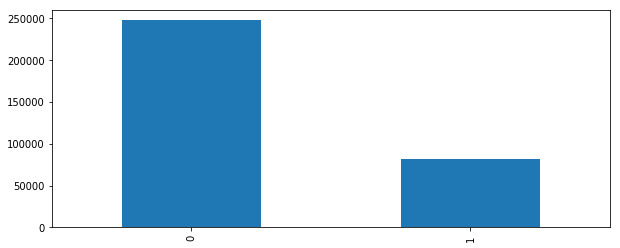

In [5]:
plt.figure(figsize=(10,4))
data["PASSER_PRO_BOWL"].value_counts().plot(kind='bar')

## Aggregating per-play data into season-long data

There are a huge number of passes thrown by quarterbacks. Because Pro-Bowl elections are made on a per-season basis, it makes it difficult to assess whether individual plays are "Pro-Bowl Quality". After all, even the best quarterbacks will throw interceptions and have incomplete passes.


In [6]:
#Too many pass attemps, lets group them group into a per season/passer
#df.groupby(['PASSER', 'SEAS']).size()

df_passer_by_season = data.groupby(['PASSER', 'SEAS']).agg({
    'PASSER': np.min, 
    'PASSER_SEAS': np.min, 
    'PASSER_PRO_BOWL': np.max, 
    'PASS_RAT': np.mean, 
    'PASS_ATTEMPT': np.sum,
    'COMP': np.sum,
    'PASSER_DRAFT_SPOT': np.max, 
    'PASSER_DRAFTED': np.max, 
    'DEEP_PASS': np.mean,  
    'MED_PASS': np.mean, 
    'SHORT_PASS': np.mean, 
    'YDS': np.sum, 
    'TD': np.sum, 
    'INTRCPT': np.sum, 
    'PASSER_HGHT': np.max,  
    'PASSER_AGE': np.max, 
    'PASSER_CAREER_STRT': np.max, 
    'TGT_HGHT': np.mean, 
    'TGT_WGHT': np.mean, 
    'TARGET_PRO_BOWL': np.mean,  
    'TGT_AGE': np.mean, 
    'TGT_DRAFT_SPOT': np.mean, 
    'TGT_DRAFTED': np.mean, 
    'TGT_CAREER_STRT': np.mean, 
    'TGT_FORTY': np.mean,  
    'TGT_VERT':np.mean, 
    'RB_TGT': np.mean,  
    'WR_TGT': np.mean, 
    'TE_TGT': np.mean,  
    'TRICK_PLAY': np.mean, 
    'FIRST_DOWN_CONVERSION': np.mean, 
    'RED_ZONE_ATTMPT': np.mean, 
    'RED_ZONE_QB_RAT': np.mean , 
    'FOURTH_DOWN_SUCCESS': np.mean, 
    'THIRD_DOWN_SUCCESS': np.mean, 
    'FOURTH_QTR_PASS_RAT': np.mean,  
    'SHOTGUN': np.mean,  
    'NO_HUDDLE': np.mean, 
    'DEF_PENALTY_DCLND': np.sum, 
    'FREE_PLAY_PASS_RAT': np.mean,  
    'SEAS': np.max,  
    'GOOD_WEATH': np.mean,  
    'DOME_GAME': np.mean,  
    'TURF_FIELD': np.mean,                               
    'SEAS': np.min,
    'POSTSEASON': np.max,
    'DIVISIONAL_APPEARANCE': np.max,
    'PASSER_PRO_BOWL_LAST_YEAR': np.max,
    'RUSH_YDS': np.sum,
    'RUSH_SUCCESS': np.mean,
    'RUSH_TD': np.sum,
    'FUMBLE': np.sum
                                   })

df_passer_by_season


PASSER           PASSER_SEAS  PASSER_PRO_BOWL  \
PASSER         SEAS                                                          
A.Andrews      2015       A.Andrews       A.Andrews, 2015                0   
A.Battle       2005        A.Battle        A.Battle, 2005                0   
               2006        A.Battle        A.Battle, 2006                0   
A.Boldin       2003        A.Boldin        A.Boldin, 2003                1   
               2005        A.Boldin        A.Boldin, 2005                1   
               2010        A.Boldin        A.Boldin, 2010                0   
               2014        A.Boldin        A.Boldin, 2014                0   
A.Brooks       2000        A.Brooks        A.Brooks, 2000                0   
               2001        A.Brooks        A.Brooks, 2001                0   
               2002        A.Brooks        A.Brooks, 2002                0   
               2003        A.Brooks        A.Brooks, 2003                0   
               2004        A.Brooks        A.Brooks, 2004                0   
               2005        A.Brooks        A.Brooks, 2005                0   
               2006        A.Brooks        A.Brooks, 2006                0   
A.Brown        2012         A.Brown         A.Brown, 2012                0   
               2013         A.Brown         A.Brown, 2013                1   
               2014         A.Brown         A.Brown, 2014                1   
A.Cason        2003         A.Cason         A.Cason, 2003                0   
A.Dalton       2011        A.Dalton        A.Dalton, 2011                0   
               2012        A.Dalton        A.Dalton, 2012                0   
               2013        A.Dalton        A.Dalton, 2013                0   
               2014        A.Dalton        A.Dalton, 2014                1   
               2015        A.Dalton        A.Dalton, 2015                1   
               2016        A.Dalton        A.Dalton, 2016                1   
               2017        A.Dalton        A.Dalton, 2017                0   
A.Davis        2014         A.Davis         A.Davis, 2014                0   
               2015         A.Davis         A.Davis, 2015                0   
A.Echemandu    2004     A.Echemandu     A.Echemandu, 2004                0   
A.Edwards      2010       A.Edwards       A.Edwards, 2010                0   
               2011       A.Edwards       A.Edwards, 2011                0   
...                             ...                   ...              ...   
T.Tupa         2001          T.Tupa          T.Tupa, 2001                0   
               2002          T.Tupa          T.Tupa, 2002                0   
T.Way          2016           T.Way           T.Way, 2016                0   
T.Yates        2011         T.Yates         T.Yates, 2011                0   
               2012         T.Yates         T.Yates, 2012                0   
               2013         T.Yates         T.Yates, 2013                0   
               2014         T.Yates         T.Yates, 2014                0   
               2015         T.Yates         T.Yates, 2015                0   
               2017         T.Yates         T.Yates, 2017                0   
V.Testaverde   2000    V.Testaverde    V.Testaverde, 2000                0   
               2001    V.Testaverde    V.Testaverde, 2001                0   
               2002    V.Testaverde    V.Testaverde, 2002                0   
               2003    V.Testaverde    V.Testaverde, 2003                0   
               2004    V.Testaverde    V.Testaverde, 2004                0   
               2005    V.Testaverde    V.Testaverde, 2005                0   
               2006    V.Testaverde    V.Testaverde, 2006                0   
               2007    V.Testaverde    V.Testaverde, 2007                0   
V.Young        2006         V.Young         V.Young, 2006                1   
               2007         V.Young         V.Young

## Let's take a preliminary look at our data

Here, we use Passer Rating as a measure of efficiency, and the number of passes attempted. Let's see what our data looks like once it has been aggregated into its rawest form

Text(0,0.5,'Passer Rating')

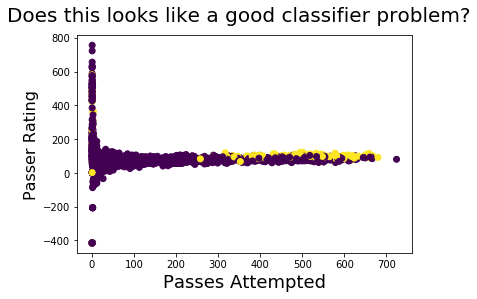

In [7]:
plt.scatter(df_passer_by_season.PASS_ATTEMPT, df_passer_by_season.PASS_RAT , c=df_passer_by_season.PASSER_PRO_BOWL)
plt.suptitle('Does this looks like a good classifier problem?', fontsize=20)
plt.xlabel('Passes Attempted', fontsize=18)
plt.ylabel('Passer Rating', fontsize=16)



## Removing quarterbacks with small sample sizes

Lots of quarterbacks (or other players) attempts a handfull of passes each year. These trick plays are not sustainable over the course of a season, and should be excluded from our classifier. While we are removing those quarterbacks with small sample size, let's also remove the last year of our data, 2017. This will allow us to train a model using 16 years of data, and then test that model on the 2017 data to see how accurate it is.

In [35]:
pass_limit = 35
season_limit = 2018

#Removing passers with limited pass sample size
df_passer_by_season_qb = df_passer_by_season.loc[(df_passer_by_season['PASS_ATTEMPT'] > pass_limit) & (df_passer_by_season['SEAS'] < season_limit)]



## Now let's look again after removing outliers

Yellow = Pro-Bowler

Purple = Non-Pro-Bowler

How are we are doing now?

Text(0,0.5,'Passer Rating')

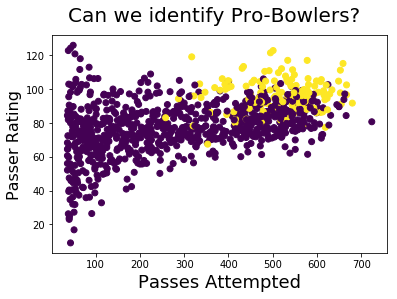

In [36]:
plt.scatter(df_passer_by_season_qb.PASS_ATTEMPT, df_passer_by_season_qb.PASS_RAT , c=df_passer_by_season_qb.PASSER_PRO_BOWL)
plt.suptitle('Can we identify Pro-Bowlers?', fontsize=20)
plt.xlabel('Passes Attempted', fontsize=18)
plt.ylabel('Passer Rating', fontsize=16)

This looks like a much more solveable classifier problem.


Now that we think we are going in the right direction, let's take a deeper look at our model training data.
## Checking our data for missing values and general quality

In [37]:
df_passer_by_season_qb.describe()

,PASSER_PRO_BOWL,PASS_RAT,PASS_ATTEMPT,COMP,PASSER_DRAFT_SPOT,PASSER_DRAFTED,DEEP_PASS,MED_PASS,SHORT_PASS,YDS,...,FREE_PLAY_PASS_RAT,GOOD_WEATH,DOME_GAME,TURF_FIELD,POSTSEASON,DIVISIONAL_APPEARANCE,PASSER_PRO_BOWL_LAST_YEAR,RUSH_SUCCESS,RUSH_TD,FUMBLE
count,957.00000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,...,439.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,934.000000,934.000000,934.000000
mean,0.15465,79.824501,315.834901,192.696970,96.429467,0.863114,0.123049,0.352474,0.524477,2211.717868,...,195.882756,0.922026,0.161227,0.417287,0.319749,0.207941,0.149425,0.505481,1.041756,2.211991
std,0.36176,16.152182,187.664449,120.679258,95.750976,0.343907,0.094300,0.466513,0.379206,1416.546098,...,101.749075,0.122279,0.223232,0.284051,0.466623,0.406047,0.356694,0.195473,1.613638,2.042954
min,0.00000,8.963178,36.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,126.000000,...,102.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,70.963542,135.000000,79.000000,8.000000,1.000000,0.000000,0.008086,0.000000,872.000000,...,133.333333,0.872385,0.000000,0.187500,0.000000,0.000000,0.000000,0.400000,0.000000,1.000000
50%,0.00000,80.527778,313.000000,184.000000,60.000000,1.000000,0.159794,0.020089,0.771993,2109.000000,...,154.166667,1.000000,0.070281,0.351585,0.000000,0.000000,0.000000,0.520000,0.000000,2.000000
75%,0.00000,90.379512,487.000000,297.000000,187.000000,1.000000,0.195402,1.000000,0.811352,3429.000000,...,205.555556,1.000000,0.190972,0.674185,1.000000,0.000000,0.000000,0.625000,1.000000,3.000000
max,1.00000,126.062925,724.000000,471.000000,285.000000,1.000000,0.324324,1.000000,0.930233,5476.000000,...,652.083333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,13.000000


In [38]:
#Check how many null values remain for our sample size
df_passer_by_season_qb.isnull().sum()

PASSER                         0
PASSER_SEAS                    0
PASSER_PRO_BOWL                0
PASS_RAT                       0
PASS_ATTEMPT                   0
COMP                           0
PASSER_DRAFT_SPOT              0
PASSER_DRAFTED                 0
DEEP_PASS                      0
MED_PASS                       0
SHORT_PASS                     0
YDS                            0
TD                             0
INTRCPT                        0
PASSER_HGHT                    0
PASSER_AGE                     0
PASSER_CAREER_STRT             0
TGT_HGHT                       0
TGT_WGHT                       0
TARGET_PRO_BOWL                0
TGT_AGE                        0
TGT_DRAFT_SPOT                 0
TGT_DRAFTED                    0
TGT_CAREER_STRT                0
TGT_FORTY                      0
TGT_VERT                       0
RB_TGT                         0
WR_TGT                         0
TE_TGT                         0
TRICK_PLAY                     0
FIRST_DOWN

## We've found missing data - let's handle it
There are a couple columns that are missing some data. One column in particular, FREE_PLAY_PASS_RAT is missing data for nearly half of the data (482/906 records!). We can safely remove that column because it won't be reliable enough to use.

Some columns are only missing a couple records worth of data. Because those columns have been aggregated into percentage columns, we can use the population's mean to fill in that small set of missing data. 

While we are missing data, let's also remove some label columns so that our data is entirely numeric, and is starting to look model ready.

In [39]:

## Removing label columns and columns missing significant data
df_passer_by_season_qb_nums_only = df_passer_by_season_qb.drop(['PASSER', 'PASSER_SEAS', 'FREE_PLAY_PASS_RAT'], axis=1)
print("Removed 3 columns to convert all data to numerical, removing missing 4th down data.")


#Fill in a few missing records with the average
df_passer_by_season_qb_nums_only = df_passer_by_season_qb_nums_only.fillna(df_passer_by_season_qb_nums_only.median())
df_passer_by_season_qb_nums_only.isnull().sum()


Removed 3 columns to convert all data to numerical, removing missing 4th down data.


PASSER_PRO_BOWL              0
PASS_RAT                     0
PASS_ATTEMPT                 0
COMP                         0
PASSER_DRAFT_SPOT            0
PASSER_DRAFTED               0
DEEP_PASS                    0
MED_PASS                     0
SHORT_PASS                   0
YDS                          0
TD                           0
INTRCPT                      0
PASSER_HGHT                  0
PASSER_AGE                   0
PASSER_CAREER_STRT           0
TGT_HGHT                     0
TGT_WGHT                     0
TARGET_PRO_BOWL              0
TGT_AGE                      0
TGT_DRAFT_SPOT               0
TGT_DRAFTED                  0
TGT_CAREER_STRT              0
TGT_FORTY                    0
TGT_VERT                     0
RB_TGT                       0
WR_TGT                       0
TE_TGT                       0
TRICK_PLAY                   0
FIRST_DOWN_CONVERSION        0
RED_ZONE_ATTMPT              0
RED_ZONE_QB_RAT              0
FOURTH_DOWN_SUCCESS          0
THIRD_DO

## We're about to enter Data Science Land!
### Let's import some data science packages

In [40]:
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


## Checking correlation between feature attributes

In [41]:
corr_matrix = df_passer_by_season_qb_nums_only.corr().abs()
corr_matrix
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
print("Here are the features that are highly correlated with each other:")
high_corr_var

Here are the features that are highly correlated with each other:


[('PASS_ATTEMPT', 'COMP'),
 ('PASS_ATTEMPT', 'YDS'),
 ('PASS_ATTEMPT', 'TD'),
 ('COMP', 'YDS'),
 ('COMP', 'TD'),
 ('DEEP_PASS', 'MED_PASS'),
 ('DEEP_PASS', 'SHORT_PASS'),
 ('MED_PASS', 'SHORT_PASS'),
 ('YDS', 'TD'),
 ('TGT_CAREER_STRT', 'SHOTGUN')]

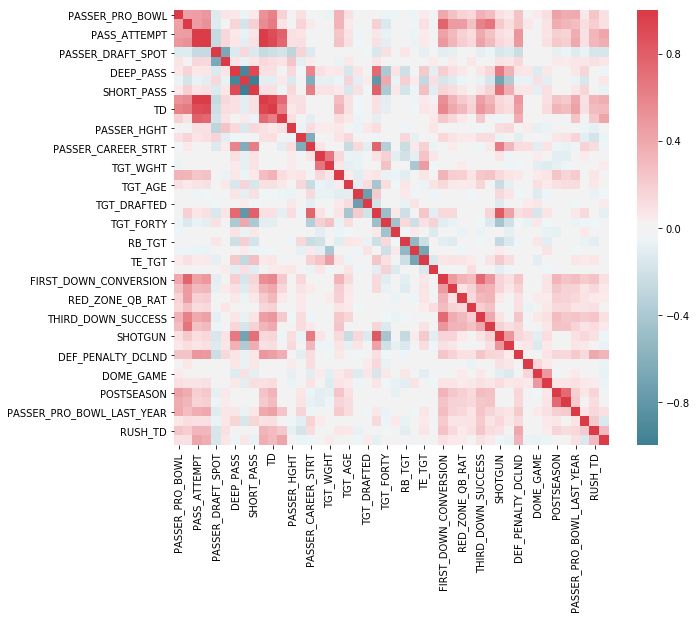

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_passer_by_season_qb_nums_only.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

##  Let's standardize the data

In [43]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df_passer_by_season_qb_nums_only)
df_standardized = pd.DataFrame(train_data,index=train_data[:,0])
df_standardized.columns = [
'PASSER_PRO_BOWL',
'PASS_RAT',
'PASS_ATTEMPT',
'COMP',
'PASSER_DRAFT_SPOT',
'PASSER_DRAFTED',
'DEEP_PASS',
'MED_PASS',
'SHORT_PASS',
'YDS',
'TD',
'INTRCPT',
'PASSER_HGHT',
'PASSER_AGE',
'PASSER_CAREER_STRT',
'TGT_HGHT',
'TGT_WGHT',
'TARGET_PRO_BOWL',
'TGT_AGE',
'TGT_DRAFT_SPOT',
'TGT_DRAFTED',
'TGT_CAREER_STRT',
'TGT_FORTY',
'TGT_VERT',
'RB_TGT',
'WR_TGT',
'TE_TGT',
'TRICK_PLAY',
'FIRST_DOWN_CONVERSION',
'RED_ZONE_ATTMPT',
'RED_ZONE_QB_RAT',
'FOURTH_DOWN_SUCCESS',
'THIRD_DOWN_SUCCESS',
'FOURTH_QTR_PASS_RAT',
'SHOTGUN',
'NO_HUDDLE',
'DEF_PENALTY_DCLND',
'SEAS',
'GOOD_WEATH',
'DOME_GAME',
'TURF_FIELD',
'POSTSEASON',
'DIVISIONAL_APPEARANCE',
'PASSER_PRO_BOWL_LAST_YEAR',
'RUSH_YDS',
'RUSH_SUCCESS',
'RUSH_TD',
'FUMBLE']

df_standardized.head(3)


,PASSER_PRO_BOWL,PASS_RAT,PASS_ATTEMPT,COMP,PASSER_DRAFT_SPOT,PASSER_DRAFTED,DEEP_PASS,MED_PASS,SHORT_PASS,YDS,...,GOOD_WEATH,DOME_GAME,TURF_FIELD,POSTSEASON,DIVISIONAL_APPEARANCE,PASSER_PRO_BOWL_LAST_YEAR,RUSH_YDS,RUSH_SUCCESS,RUSH_TD,FUMBLE
0.0,0.0,0.655460,0.229651,0.214912,0.457746,1.0,0.0,1.0,0.0,0.259439,...,1.000000,0.820513,0.820513,1.0,1.0,0.0,0.174832,0.500000,0.142857,0.153846
0.0,0.0,0.578144,0.755814,0.651316,0.457746,1.0,0.0,1.0,0.0,0.692710,...,0.836220,0.584252,0.636220,0.0,0.0,0.0,0.359270,0.392405,0.071429,0.692308
0.0,0.0,0.607875,0.719477,0.587719,0.457746,1.0,0.0,1.0,0.0,0.640374,...,0.922945,0.618151,0.688356,0.0,0.0,0.0,0.263208,0.547170,0.142857,0.307692


## Now let's rerun that correlation to see what changed

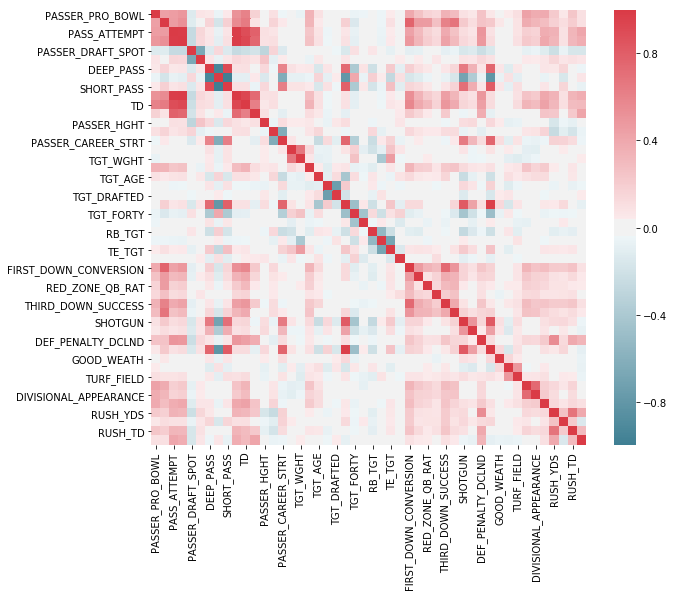

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_standardized.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Correlation looks the same after standardization

Well. Turns out seaborn already does standardize your data (in the background) before running a correlation heatmap.
That's ok, we still needed to standardize our data before we run it through any kind of predictive classifier.

### Let's take a deeper look at the distribution of our data for each model feature
Double click below to expand the chart and look at each individual feature's distribution


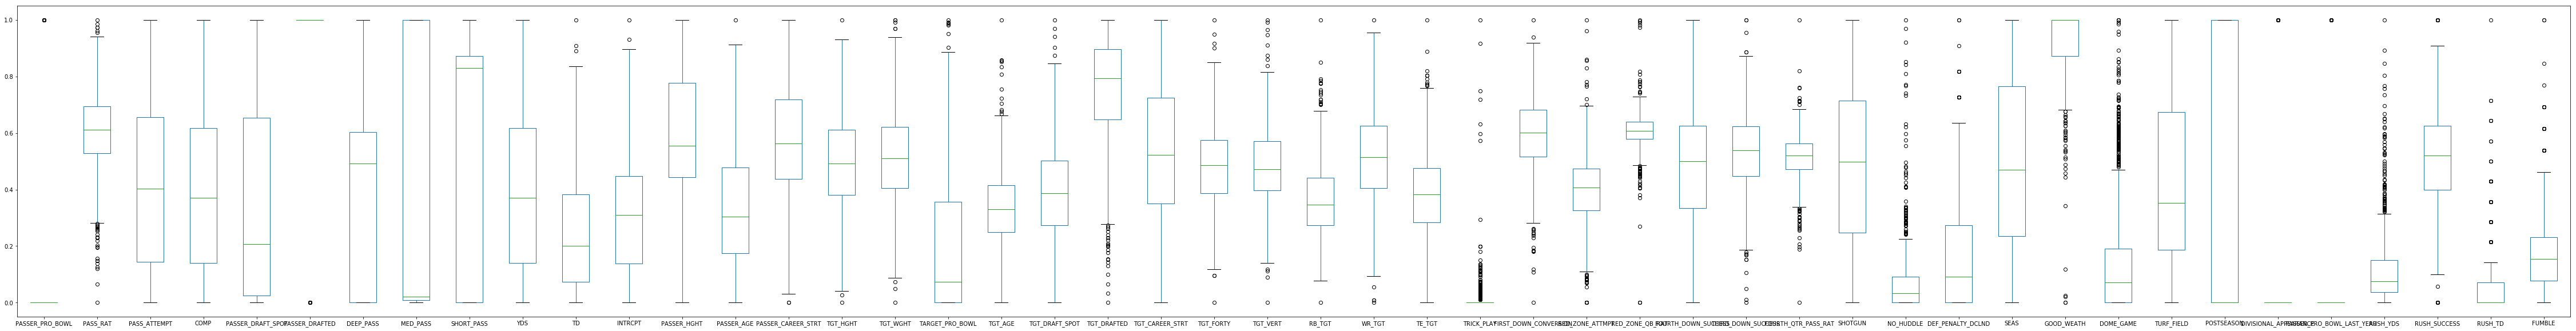

In [45]:
df_standardized.plot.box(figsize=(80,10))

## Let's officially define our features and target
Until now, we've been looking at both of those combined in one dataframe, without ever calling out which is the target

In [46]:
features = df_standardized.drop(['PASSER_PRO_BOWL'], axis=1)
labels   = df_standardized['PASSER_PRO_BOWL']

## Regularization & Feature selection
Time to determine which of those features will be used in our model

In [47]:
## Lasso 
model = Lasso()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('PASS_RAT', 0.0), ('PASS_ATTEMPT', 0.0), ('COMP', 0.0), ('PASSER_DRAFT_SPOT', -0.0), ('PASSER_DRAFTED', 0.0), ('DEEP_PASS', 0.0), ('MED_PASS', -0.0), ('SHORT_PASS', 0.0), ('YDS', 0.0), ('TD', 0.0), ('INTRCPT', 0.0), ('PASSER_HGHT', -0.0), ('PASSER_AGE', 0.0), ('PASSER_CAREER_STRT', -0.0), ('TGT_HGHT', -0.0), ('TGT_WGHT', -0.0), ('TARGET_PRO_BOWL', 0.0), ('TGT_AGE', 0.0), ('TGT_DRAFT_SPOT', 0.0), ('TGT_DRAFTED', -0.0), ('TGT_CAREER_STRT', 0.0), ('TGT_FORTY', -0.0), ('TGT_VERT', -0.0), ('RB_TGT', 0.0), ('WR_TGT', -0.0), ('TE_TGT', 0.0), ('TRICK_PLAY', 0.0), ('FIRST_DOWN_CONVERSION', 0.0), ('RED_ZONE_ATTMPT', 0.0), ('RED_ZONE_QB_RAT', 0.0), ('FOURTH_DOWN_SUCCESS', 0.0), ('THIRD_DOWN_SUCCESS', 0.0), ('FOURTH_QTR_PASS_RAT', 0.0), ('SHOTGUN', 0.0), ('NO_HUDDLE', 0.0), ('DEF_PENALTY_DCLND', 0.0), ('SEAS', 0.0), ('GOOD_WEATH', 0.0), ('DOME_GAME', 0.0), ('TURF_FIELD', 0.0), ('POSTSEASON', 0.0), ('DIVISIONAL_APPEARANCE', 0.0), ('PASSER_PRO_BOWL_LAST_YEAR', 0.0), ('RUSH_YDS', 0.0), ('RUSH_SUCCE

In [48]:
model = Ridge()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('PASS_RAT', -0.3369982623545577), ('PASS_ATTEMPT', -0.38575423306747314), ('COMP', 0.21275237388062238), ('PASSER_DRAFT_SPOT', -0.009925970965171713), ('PASSER_DRAFTED', 0.018606114863806804), ('DEEP_PASS', 0.06506641039843429), ('MED_PASS', -0.0232011916421128), ('SHORT_PASS', 0.002255964957454496), ('YDS', 0.45374480919174154), ('TD', 0.9822330900756464), ('INTRCPT', -0.5928721801189347), ('PASSER_HGHT', -0.07666118859724198), ('PASSER_AGE', -0.01914634551959819), ('PASSER_CAREER_STRT', -0.03180463983077621), ('TGT_HGHT', 0.11920300607817032), ('TGT_WGHT', -0.19367710450754777), ('TARGET_PRO_BOWL', 0.19147612669935934), ('TGT_AGE', -0.03841501992726894), ('TGT_DRAFT_SPOT', 0.0717272902740398), ('TGT_DRAFTED', 0.0027054741934982762), ('TGT_CAREER_STRT', 0.016751433487724166), ('TGT_FORTY', -0.041539320521270934), ('TGT_VERT', -0.015917437900472786), ('RB_TGT', 0.06428320650701534), ('WR_TGT', -0.07235419474273633), ('TE_TGT', 0.025778789760419866), ('TRICK_PLAY', 0.02417918316614502

In [49]:
model = ElasticNet()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('PASS_RAT', 0.0), ('PASS_ATTEMPT', 0.0), ('COMP', 0.0), ('PASSER_DRAFT_SPOT', -0.0), ('PASSER_DRAFTED', 0.0), ('DEEP_PASS', 0.0), ('MED_PASS', -0.0), ('SHORT_PASS', 0.0), ('YDS', 0.0), ('TD', 0.0), ('INTRCPT', 0.0), ('PASSER_HGHT', -0.0), ('PASSER_AGE', 0.0), ('PASSER_CAREER_STRT', -0.0), ('TGT_HGHT', -0.0), ('TGT_WGHT', -0.0), ('TARGET_PRO_BOWL', 0.0), ('TGT_AGE', 0.0), ('TGT_DRAFT_SPOT', 0.0), ('TGT_DRAFTED', -0.0), ('TGT_CAREER_STRT', 0.0), ('TGT_FORTY', -0.0), ('TGT_VERT', -0.0), ('RB_TGT', 0.0), ('WR_TGT', -0.0), ('TE_TGT', 0.0), ('TRICK_PLAY', 0.0), ('FIRST_DOWN_CONVERSION', 0.0), ('RED_ZONE_ATTMPT', 0.0), ('RED_ZONE_QB_RAT', 0.0), ('FOURTH_DOWN_SUCCESS', 0.0), ('THIRD_DOWN_SUCCESS', 0.0), ('FOURTH_QTR_PASS_RAT', 0.0), ('SHOTGUN', 0.0), ('NO_HUDDLE', 0.0), ('DEF_PENALTY_DCLND', 0.0), ('SEAS', 0.0), ('GOOD_WEATH', 0.0), ('DOME_GAME', 0.0), ('TURF_FIELD', 0.0), ('POSTSEASON', 0.0), ('DIVISIONAL_APPEARANCE', 0.0), ('PASSER_PRO_BOWL_LAST_YEAR', 0.0), ('RUSH_YDS', 0.0), ('RUSH_SUCCE

## Regularization Results:
### Lasso: 0 features
### Ridge: All features
### ElasticNet:  0 features

Let's keep all the features we have selected to this point (thanks, Ridge!). After all, we've already removed a lot of highly collerated features.

=================================================================================================================

## Let's revisit our model data

For our training data, we've removed 2017 and those passers with less than 35 pass attempts.
We haven't yet identified our training/test data.
First, we'll remove 2017 and then standardize our data. We'll carve out the features from the target so we can run them through a classifier.

In [50]:
# repull data prior to its earlier standardization
model_data = df_passer_by_season_qb_nums_only
train_cutoff_dt = 2012

#data for modeling , before 2017 data
train_model_data = model_data[model_data['SEAS'] < train_cutoff_dt]

## standardize data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_model_data)
train_model_data = pd.DataFrame(train_data,index=train_data[:,0])

## Separate out the features from the target (all standardized now)
train_features = train_model_data.iloc[:, 1:41]
train_target = train_model_data.iloc[:, 0]

print("Training data ready to go.. will train model using data before", train_cutoff_dt)


Training data ready to go.. will train model using data before 2012


In [51]:
#data for testing, 2017 onwards - full season data
test_model_data = model_data[model_data['SEAS'] >= train_cutoff_dt]

## standardize data
scaler = MinMaxScaler()
test_data = scaler.fit_transform(test_model_data)
test_model_data = pd.DataFrame(test_data)

## Separate out the features from the target (all standardized now)
test_features = test_model_data.iloc[:, 1:41]
test_target = test_model_data.iloc[:, 0]

print("Testing data ready to go.. will test data based on the", train_cutoff_dt, "season and afterwards")

Testing data ready to go.. will test data based on the 2012 season and afterwards


If we take a look at the shape of our data, you'll see that we have 960 sample quarterbacks in our 17 year span. We'll be training our models using a split sample from the 906 quarterbacks that were playing prior to 2017. After we determine which model is giving us the best results, we can run the full training data (all 906 records) to get a better fit. After that, we can run our model on 2017 data (real results), and start tuning our hyperparameters to see what gets the best results without overfitting our data.

In [52]:
print("Original Data shape. Rows, Columns :", model_data.shape)
print("Training Data shape. Rows, Columns :", train_features.shape)
print("Prediction Population Data shape. Rows, Columns :", test_features.shape)
print("Training Target shape. Rows, Columns :", train_target.shape)
print("Prediction Population Target shape. Rows, Columns :", test_target.shape)

Original Data shape. Rows, Columns : (957, 48)
Training Data shape. Rows, Columns : (652, 40)
Prediction Population Data shape. Rows, Columns : (305, 40)
Training Target shape. Rows, Columns : (652,)
Prediction Population Target shape. Rows, Columns : (305,)


## Splitting our training data
Because we don't have too much data (only ~1,000 records), let's keep the our training split size fairly large. Since are assigning the test size first, the training size is implictly determined by our smaller test size.

In [53]:
# Identify our data and target 
x = train_features
y = train_target

# Create random train and test splits to avoid bais and overfitting
splits = tts(x, y, test_size=.2)
x_train, x_test, y_train, y_test = splits

x_train.shape

(521, 40)

In [54]:
results=[]
names=[]

def fit_model(model, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test):
    start = time.time()
    model.fit(x_train, y_train)
    duration = time.time() - start 
    score = model.score(x_test, y_test)
    
    print("{} fit in {:0.2f} seconds score: {:0.4f}".format(model.__class__.__name__, duration, score))
    #print(model.get_params()) 
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    #print(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
    

LogisticRegression fit in 0.00 seconds score: 0.9313
KNeighborsClassifier fit in 0.00 seconds score: 0.9313
DecisionTreeClassifier fit in 0.01 seconds score: 0.8550
RandomForestClassifier fit in 0.02 seconds score: 0.9313
GaussianNB fit in 0.00 seconds score: 0.8168
SVC fit in 0.01 seconds score: 0.9008


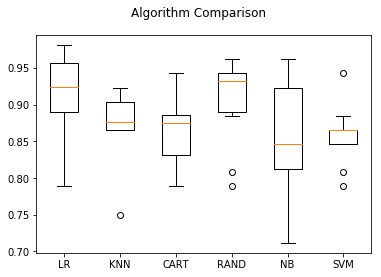

In [55]:
# prepare models


models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RAND', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

    
for name,model in models:
    fit_model(model)    
    
    # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [56]:
x = test_features
y = test_target
def predict_model(model):
    yhat = model.predict(test_features)
    #r2 = r2_score(target_predict, yhat)
    #me = mse(target_predict, yhat)
    #print("r2={:0.3f} MSE={:0.3f}".format(r2,me))
    print(name, model)
    print(classification_report(y, yhat))
    print(yhat)
    
for name, model in models:
    predict_model(model) 

LR LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

        0.0       0.92      0.92      0.92       244
        1.0       0.68      0.67      0.68        61

avg / total       0.87      0.87      0.87       305

[ 1.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  

C:\Users\Doug\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



## How do those results look?
### Logistic Regression & KNN: Results look reasonable.
### Decision Tree: Forecasts too many players making the Pro-Bowl.
### Random Forest: Pretty good results.
### Gaussian & SVM: Predicted nobody made the Pro-Bowl :(

Those results are all over the place.. But there is hope after seeing the auto-generated results. Let's take a deeper look at some of these models, and try tuning the hyper-parameters to see if we can get some better results

### Let's try tuning KNN's hyperparameters
First, we'll start by modifying how many nearest neighbors are used in the algorithm

In [63]:
clf = KNeighborsClassifier(n_neighbors = 3)
clf.fit(train_features, train_target)
#x_train
score = clf.score(test_features, test_target)
pred_rslt = clf.predict(test_features)

print(classification_report(test_target, pred_rslt))

##print("Predicted:", pred_rslt)
##print("Actual : ", y_test)
print("Top: Predicted 0, Predicted ProBowl")
print("Left: Actual 0, Actual ProBowl")
confusion_matrix(test_target, pred_rslt)

model_rslt_conf_matx = DataFrame(confusion_matrix(test_target, pred_rslt), index = ['NON_PRO_BOWL', 'ACT_PRO_BOWL'])
model_rslt_conf_matx.columns = ['PREDICTED_NON_PRO_BOWLER', 'PREDICTED_PRO_BOWLER']
model_rslt_conf_matx

             precision    recall  f1-score   support

        0.0       0.87      0.95      0.91       244
        1.0       0.70      0.43      0.53        61

avg / total       0.84      0.85      0.83       305

Top: Predicted 0, Predicted ProBowl
Left: Actual 0, Actual ProBowl


,PREDICTED_NON_PRO_BOWLER,PREDICTED_PRO_BOWLER
NON_PRO_BOWL,233,11
ACT_PRO_BOWL,35,26


### Let's take a deep dive in the Random Forest Classifier - easily the best performing model so far

In [64]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(train_features, train_target)
#x_train
score = clf.score(test_features, test_target)
pred_rslt = clf.predict(test_features)

print(classification_report(test_target, pred_rslt))

##print("Predicted:", pred_rslt)
##print("Actual : ", y_test)
print("Top: Predicted 0, Predicted ProBowl")
print("Left: Actual 0, Actual ProBowl")
model_rslt_conf_matx = DataFrame(confusion_matrix(test_target, pred_rslt), index = ['NON_PRO_BOWL', 'ACT_PRO_BOWL'])
model_rslt_conf_matx.columns = ['PREDICTED_NON_PRO_BOWLER', 'PREDICTED_PRO_BOWLER']
model_rslt_conf_matx

             precision    recall  f1-score   support

        0.0       0.83      1.00      0.91       244
        1.0       1.00      0.20      0.33        61

avg / total       0.87      0.84      0.79       305

Top: Predicted 0, Predicted ProBowl
Left: Actual 0, Actual ProBowl


,PREDICTED_NON_PRO_BOWLER,PREDICTED_PRO_BOWLER
NON_PRO_BOWL,244,0
ACT_PRO_BOWL,49,12


In [90]:
clf = LogisticRegression(penalty='l1', dual=False, tol=0.00001, C=.8, fit_intercept=True, class_weight=None, solver='liblinear')
clf.fit(train_features, train_target)
#x_train ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
score = clf.score(test_features, test_target)
pred_rslt = clf.predict(test_features)

print(classification_report(test_target, pred_rslt))

##print("Predicted:", pred_rslt)
##print("Actual : ", y_test)
print("Top: Predicted 0, Predicted ProBowl")
print("Left: Actual 0, Actual ProBowl")
model_rslt_conf_matx = DataFrame(confusion_matrix(test_target, pred_rslt), index = ['NON_PRO_BOWL', 'ACT_PRO_BOWL'])
model_rslt_conf_matx.columns = ['PREDICTED_NON_PRO_BOWLER', 'PREDICTED_PRO_BOWLER']
model_rslt_conf_matx

             precision    recall  f1-score   support

        0.0       0.94      0.92      0.93       244
        1.0       0.71      0.75      0.73        61

avg / total       0.89      0.89      0.89       305

Top: Predicted 0, Predicted ProBowl
Left: Actual 0, Actual ProBowl


,PREDICTED_NON_PRO_BOWLER,PREDICTED_PRO_BOWLER
NON_PRO_BOWL,225,19
ACT_PRO_BOWL,15,46


In [67]:
 #yhat = model.predict(dt_predict_data)
    #print(classification_report(y, yhat))
d= df_passer_by_season_qb.loc[(df_passer_by_season_qb["SEAS"]>=train_cutoff_dt), ['PASSER_SEAS', 'PASSER_PRO_BOWL', 'PASS_RAT', 'PASS_ATTEMPT']] 

    #print("Season: {}, 0s: {}, 1s:{}".format(seas,len(X[X['INPROBOWLTEAM'] ==0]),len(X[X['INPROBOWLTEAM'] ==1])))
    #unmatched_results = d.loc[( d['yhat'] != d['INPROBOWLTEAM'])]
    #matched_results = d.loc[( d['yhat'] == d['INPROBOWLTEAM'])]
pred_rslt_df = DataFrame(pred_rslt)
pred_rslt_df.columns = ['PREDICTION']

#d = d.copy()

d.reset_index(inplace=True)
#d["Model_Prediction"] = pred_rslt_df
verify_results = d.join(pred_rslt_df)
verify_results.head(10)

,PASSER,SEAS,PASSER_SEAS,PASSER_PRO_BOWL,PASS_RAT,PASS_ATTEMPT,PREDICTION
0,A.Dalton,2012,"A.Dalton, 2012",0,87.869048,525.0,1.0
1,A.Dalton,2013,"A.Dalton, 2013",0,88.928063,585.0,1.0
2,A.Dalton,2014,"A.Dalton, 2014",1,83.493590,481.0,0.0
3,A.Dalton,2015,"A.Dalton, 2015",1,106.250000,386.0,1.0
4,A.Dalton,2016,"A.Dalton, 2016",1,92.145722,561.0,0.0
5,A.Dalton,2017,"A.Dalton, 2017",0,86.670875,495.0,0.0
6,A.Davis,2014,"A.Davis, 2014",0,85.726950,282.0,0.0
7,A.Davis,2015,"A.Davis, 2015",0,66.223404,94.0,0.0
8,A.Luck,2012,"A.Luck, 2012",1,77.433360,619.0,1.0
9,A.Luck,2013,"A.Luck, 2013",1,87.039474,570.0,0.0


In [91]:
import plotly
plotly.tools.set_credentials_file(username='GTown2018', api_key='MMethJca31qEJ51J4Kan')

import plotly.plotly as py
import plotly.graph_objs as go


model_results_true_negative = verify_results.loc[(verify_results['PASSER_PRO_BOWL'] == 0) & (verify_results['PREDICTION'] == 0)]
model_results_false_negative = verify_results.loc[(verify_results['PASSER_PRO_BOWL'] == 1) & (verify_results['PREDICTION'] == 0)]
model_results_false_positive = verify_results.loc[(verify_results['PASSER_PRO_BOWL'] == 0) & (verify_results['PREDICTION'] == 1)]
model_results_true_positive = verify_results.loc[(verify_results['PASSER_PRO_BOWL'] == 1) & (verify_results['PREDICTION'] == 1)]

# Create a trace
trace0 = go.Scatter(
    x = model_results_true_negative.PASS_ATTEMPT,
    y = model_results_true_negative.PASS_RAT,
    mode = 'markers',
    name = 'Non-ProBowler',
        marker = dict(
        size = 5,
        color = 'rgba(100, 152, 200, .8)'),
    text= (model_results_true_negative['PASSER_SEAS'])

)

trace1 = go.Scatter(
    x = model_results_false_negative.PASS_ATTEMPT,
    y = model_results_false_negative.PASS_RAT,
    mode = 'markers',
    name = 'Missed an actual ProBowler',
        marker = dict(
        size = 10,
        color = 'rgba(50, 25, 150, .8)'),
    text= model_results_false_negative['PASSER_SEAS']

)

trace2 = go.Scatter(
    x = model_results_false_positive.PASS_ATTEMPT,
    y = model_results_false_positive.PASS_RAT,
    mode = 'markers',
    name = 'Incorrectly Predicted ProBowl',
        marker = dict(
        size = 10,
        color = 'rgba(0, 152, 50, .8)'),
    text= model_results_false_positive['PASSER_SEAS']

)


trace3 = go.Scatter(
    x = model_results_true_positive.PASS_ATTEMPT,
    y = model_results_true_positive.PASS_RAT,
    mode = 'markers',
    name = 'Pro-Bowler',
        marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)'),
    text= model_results_true_positive['PASSER_SEAS']

)


layout = go.Layout(
    title='QBs & ProBowls',
    xaxis=dict(
        title='Passes Attempted',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Passer Rating',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)



#data = [trace0, trace1]

scatter_pb = go.Figure(data = [trace3, trace2, trace1, trace0], layout=layout)

# Plot and embed in ipython notebook!
#py.iplot(data)
py.iplot(scatter_pb)


In [94]:
radviz_features = model_data.iloc[:, 1:41]
radviz_target = model_data.iloc[:, 0]
radviz_target

PASSER          SEAS
A.Brooks        2000    0
                2001    0
                2002    0
                2003    0
                2004    0
                2005    0
                2006    0
A.Dalton        2011    0
                2012    0
                2013    0
                2014    1
                2015    1
                2016    1
                2017    0
A.Davis         2014    0
                2015    0
A.Feeley        2002    0
                2004    0
                2006    0
                2007    0
                2011    0
A.Luck          2012    1
                2013    1
                2014    1
                2015    0
                2016    0
A.McCarron      2015    0
A.Rodgers       2008    0
                2009    1
                2010    0
                       ..
T.Savage        2017    0
T.Siemian       2016    0
                2017    0
T.Smith         2007    0
                2010    0
T.Taylor        2015    1
                2

In [107]:

df_passer_by_season_radviz = model_data
df_passer_by_season_radviz= df_passer_by_season_radviz.drop(['SEAS'])
df_passer_by_season_radviz.reset_index()
#df_passer_by_season_radviz= df_passer_by_season_radviz.drop(['PASSER', 'PASSER_SEAS'])

df_passer_by_season_radviz

KeyError: 'SEAS'

In [99]:
from pandas.plotting import radviz
plt.figure(figsize=(15,13))
radviz(df_passer_by_season_radviz[[
    'PASSER_PRO_BOWL', 
    'PASS_RAT', 
    'PASS_ATTEMPT', 
    'COMP', 
    'PASSER_DRAFT_SPOT', 
    'PASSER_DRAFTED', 
    'DEEP_PASS', 
    'MED_PASS', 
    'SHORT_PASS', 
    'YDS', 
    'TD', 
    'INTRCPT', 
    'PASSER_HGHT', 
    'PASSER_AGE', 
    'PASSER_CAREER_STRT', 
    'TGT_HGHT', 
    'TGT_WGHT', 
    'TARGET_PRO_BOWL', 
    'TGT_AGE', 
    'TGT_DRAFT_SPOT', 
    'TGT_DRAFTED', 
    'TGT_CAREER_STRT', 
    'TGT_FORTY', 
    'TGT_VERT', 
    'RB_TGT', 
    'WR_TGT', 
    'TE_TGT', 
    'TRICK_PLAY', 
    'FIRST_DOWN_CONVERSION', 
    'RED_ZONE_ATTMPT', 
    'RED_ZONE_QB_RAT', 
    'FOURTH_DOWN_SUCCESS', 
    'THIRD_DOWN_SUCCESS', 
    'FOURTH_QTR_PASS_RAT', 
    'SHOTGUN', 
    'NO_HUDDLE', 
    'DEF_PENALTY_DCLND', 
    'FREE_PLAY_PASS_RAT', 
    'SEAS', 
    'GOOD_WEATH', 
    'DOME_GAME', 
    'TURF_FIELD', 
    'SEAS', 
    'POSTSEASON', 
    'DIVISIONAL_APPEARANCE', 
    'PASSER_PRO_BOWL_LAST_YEAR', 
    'RUSH_YDS', 
    'RUSH_SUCCESS', 
    'RUSH_TD', 
    'FUMBLE' 
]], 'PASSER_PRO_BOWL', color=['red','green'])

NameError: name 'df_passer_by_season_radviz' is not defined